In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

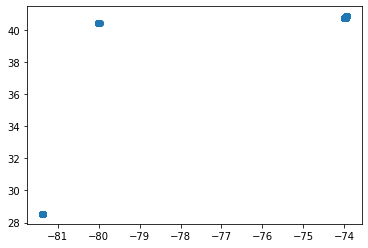

In [2]:
coords = sio.loadmat('data/GPS_Long_Lat_Compass.mat')['GPS_Compass']
plt.scatter(y=coords[:,0],x=coords[:,1])
plt.show()

As expected, the points are grouped into three clusters. These clusters are Pittsburgh, Manhattan, and Orlando

I want to get groupings for them, kmeans will probably be a convenient way of getting the correct label for each point. Given how far separated each city is from the others I can't imagine kmeans would have any trouble

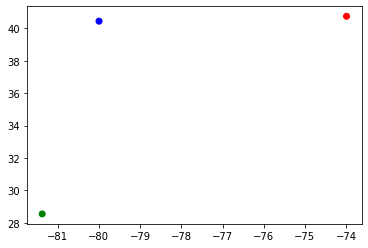

In [3]:
k3 = KMeans(n_clusters=3)
labels = k3.fit_predict(coords[:,:2])

plt.scatter(x=k3.cluster_centers_[:,1], y=k3.cluster_centers_[:,0], c=['red', 'green', 'blue'])
plt.show()

In [2]:
# Figure out which label corresponds to which city
#   Red => Manhattan
#   Green => Orlando
#   Blue => Pittsburgh
# Thus, 0:Man, 1:Orl, 2:Pit

# I can actually probably just train a model from here
from PIL import Image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [5]:
ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(labels.reshape(-1, 1))
ohe_labels = ohe_labels.todense()

In [3]:
def create_image_stack(imgid, imgfolder='data/images'):
    # 4 images per location
    imgs = np.array([
        np.asarray(Image.open(
             f'{imgfolder}/{imgid:06}_{i}.jpg'
        ).resize((90, 90)))
        for i in range(1, 5)
    ])
    # Who knows if this will perform well but whatever
    # Rather than tiling images 2x2, which I'm really not sure
    # if images are maintained in that case. I'll stack them horizontally
    # which should, I believe, keep images actually together for
    # the conv layer
    return imgs.reshape(360, 90, 3)

imgcount = 10343
# Split up into a test and train set
imgarr = np.arange(imgcount)
test = np.random.choice(imgarr, int(imgcount * 0.2))
train = np.setdiff1d(imgarr, test)

def create_batches(batchsize=32, source=train):
    # idk whether to do this inside or outside the function /shrug
    # Do I want to do this randomly?
    #    Yes. Yes I do.
    
    # The simplest will be a candidate list
    # Simplest to think about, I'm not in a position to consider optimization rn
    remain = source
    while len(remain) > 0:
        selection = np.random.choice(remain, batchsize)
        remain = np.setdiff1d(remain, selection)
        
        batch = np.array([
            create_image_stack(i + 1)
            for i in selection
        ])
        # Only take the lat/lon, ignore compass direction
        targets = ohe_labels[selection]
        yield (batch, targets)
        
def repeat_generator(genfunc, repeats=-1, **kwargs):
    # Numbers less than 0 will result in infinite repeats
    while repeats != 0:
        gen = genfunc(**kwargs)
        for res in gen:
            yield res
        repeats -= 1

In [7]:
model = Sequential()
model.add(Conv2D(64, 3, 3, input_shape=(360, 90, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='val_acc', patience=2)

model.fit(
    repeat_generator(create_batches),
    steps_per_epoch = len(train) // 32,
    epochs = 10,
    validation_data = repeat_generator(
        create_batches,
        source = test
    ),
    validation_steps = len(test) // 32,
    callbacks = [stop]
)

Epoch 1/10
264/264 [==============================] - 2792s 11s/step - loss: 51.2132 - acc: 0.7425 - val_loss: 0.4314 - val_acc: 0.8369
Epoch 2/10
264/264 [==============================] - 2385s 9s/step - loss: 0.1707 - acc: 0.9386 - val_loss: 0.3668 - val_acc: 0.8794
Epoch 3/10
264/264 [==============================] - 2384s 9s/step - loss: 0.0549 - acc: 0.9858 - val_loss: 0.3808 - val_acc: 0.8804
Epoch 4/10
264/264 [==============================] - 2048s 8s/step - loss: 0.0164 - acc: 0.9980 - val_loss: 0.3988 - val_acc: 0.8994
Epoch 5/10
264/264 [==============================] - 2096s 8s/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.5516 - val_acc: 0.8726
Epoch 6/10
264/264 [==============================] - 3010s 11s/step - loss: 0.0048 - acc: 0.9994 - val_loss: 0.4676 - val_acc: 0.8950


In [9]:
#model.save('models/classif/notest')
#model.save('models/classif/tested')
model.save('models/classif/hstack')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/classif/hstack\assets


In [10]:
def make_prediction(imgid):
    pred = model.predict(np.array([create_image_stack(imgid)]))
    label = np.argmax(pred[0])
    return k3.cluster_centers_[label]

In [11]:
print(make_prediction(757))
print(coords[757])

# Predicted pittsburg
# Actual is pittsburg

[ 40.44056225 -79.99791908]
[ 40.442884 -80.0022    23.65    ]


In [12]:
print(make_prediction(10023))
print(coords[10023])
# Accurate prediction

[ 40.7436342  -73.98924638]
[ 40.736335 -74.006645 352.97    ]


In [13]:
# Try something from the test set, I have no idea if
# those two were training or testing
preds = model.predict(np.array([
    create_image_stack(i + 1)
    for i in test[:10]
]))
pred_labels = np.argmax(preds, axis=1)
print('Predicted:')
print(k3.cluster_centers_[pred_labels])

print('Actual:')
print(coords[test[:10]])

Predicted:
[[ 40.7436342  -73.98924638]
 [ 40.44056225 -79.99791908]
 [ 28.54581482 -81.37825776]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]
 [ 40.44056225 -79.99791908]
 [ 40.7436342  -73.98924638]
 [ 40.7436342  -73.98924638]]
Actual:
[[ 40.744877 -73.978219 299.35    ]
 [ 40.434476 -79.989387 104.29    ]
 [ 28.55374  -81.376871 357.84    ]
 [ 40.755338 -73.985284 286.1     ]
 [ 40.753075 -73.989669 260.33    ]
 [ 40.750747 -73.98605  270.34    ]
 [ 40.728321 -74.002858   5.73    ]
 [ 40.443969 -79.999527 164.09    ]
 [ 40.736987 -73.995961 268.03    ]
 [ 28.542546 -81.377475 351.83    ]]


So the predictions were:
* Correct (Manhattan)
* Correct (Pittsburgh)
* Correct (Orlando)
* Correct (Manhattan) x4
* Correct (Pittsburgh)
* Correct (Manhattan)
* Wrong (P: Manhattan, A: Orlando)

----

Load the preexisting model  
The class labels I have above are (0:Manhattan, 1:Orlando, 2:Pittsburgh), I don't remember if I re-clustered since making that note but I'm not going to wait for 6 hours to retrain the whole model. So if all three predictions are wrong but otherwise consistent with each other, I can try another set of three images. If the classes for the three new images agree with the old images I'll just assume my class labels got changed since that note was written.

In [4]:
model = tf.keras.models.load_model('models/classif/hstack')
model

In [5]:
# Expect Manhattan: 0
pred = model.predict(np.array([create_image_stack(1, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Accurate prediction

[[9.9026233e-01 7.5371247e-07 9.7369617e-03]]
0


In [8]:
# Expect Pittsburgh: 2
pred = model.predict(np.array([create_image_stack(2, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Well that one was correct, I suppose?

[[3.8951387e-11 5.8648720e-07 9.9999940e-01]]
2


In [9]:
# Expect Orlando: 1
pred = model.predict(np.array([create_image_stack(3, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# That was also correct

[[1.565930e-02 9.836099e-01 7.307912e-04]]
1


In [10]:
# Maybe that one image set from Manhattan just happened to hit the 20% incorrect
# Try another manhattan picture set
# This picture is pretty sunny, I wonder if it might mis-predict as Orlando
pred = model.predict(np.array([create_image_stack(4, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Pittsburgh again...

[[9.9978548e-01 1.9111040e-04 2.3466697e-05]]
0


These two cities are fairly similar latitudes, while Orlando is much farther south  
Perhaps if the predictions are relatively accurate in terms of latitude, then
there's some kind of confusion between Pittsburgh and Manhattan.

Looking closer at the actual prediction values, I do see the Orlando picture was 100% confident. While the others, while still being 99% confident, it is the other northern city that has a relatively high chance.  
That last prediction was only 98.5% confident in Pittsburgh, then Manhattan was a whole four orders of magnitude more likely than Orlando.

In [11]:
# Last attempt at Manhattan. These look like potential landmarks I suppose
pred = model.predict(np.array([create_image_stack(5, imgfolder='data/test_images')]))
print(pred)
print(np.argmax(pred[0]))
# Only 87% confident in Pittsburgh this time.
# Manhattan got above a single percentage point.

[[9.9996960e-01 2.5503826e-07 3.0207566e-05]]
0


Making predictions in bulk, and formatting nicely

In [6]:
truevals = pd.read_csv('data/test_coords.csv')
def make_prediction(imgids):
    preds = model.predict(np.array([
        create_image_stack(i, imgfolder='data/test_images')
        for i in imgids
    ]))
    pred_labels = np.argmax(preds, axis=1)
    result = pd.DataFrame({
        'Predicted': pred_labels,
        'Actual': truevals.City.iloc[np.subtract(imgids, 1)]
    })
    model_keys = {
        0: 'M',
        1: 'O',
        2: 'P'
    }
    result.Predicted = result.Predicted.map(model_keys)
    return result

In [12]:
pred_result = make_prediction(list(range(1, 11)))
acc = (pred_result.Predicted == pred_result.Actual).sum() / pred_result.shape[0]
print(acc)
pred_result[pred_result.Predicted != pred_result.Actual]

0.7


,Predicted,Actual
6,M,P
8,M,O
9,M,O


Predicted: Manhattan, Actual: Pittsburgh


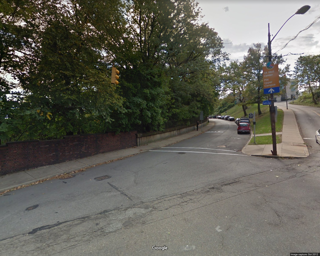

In [22]:
# Lets have a look at the incorrect images
print('Predicted: Manhattan, Actual: Pittsburgh')
Image.open('data/test_images/000007_3.jpg').resize((320, 256))

Predicted: Manhattan, Actual: Orlando


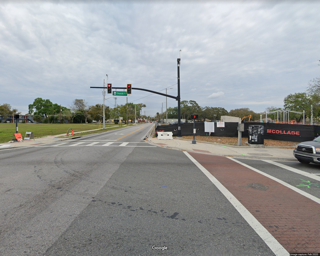

In [23]:
print('Predicted: Manhattan, Actual: Orlando')
Image.open('data/test_images/000009_1.jpg').resize((320, 256))

Predicted: Manhattan, Actual: Orlando


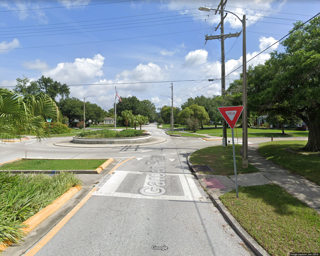

In [25]:
print('Predicted: Manhattan, Actual: Orlando')
Image.open('data/test_images/000010_1.jpg').resize((320, 256))

I'm slightly surprised by Orlando actually causing more problems this time around. The previous input shape for the model had quite a good accuracy with Orlando while getting confused between Manhattan and Pittsburgh. Though overall the model does seem to be predicting better, so I'm not at all unhappy.

---

Get a bunch more images and try them out, I really don't have many test images that are not only separate from what was trained on but also completely different from the entire dataset. It's conceivable given the accuracy on training data that the model is overfit, but possibly overfit on some sort of artifact in the pictures themselves relating to the times/dates they were taken as opposed to the actual content of the picture.

In [13]:
pred_result = make_prediction(list(range(1, 35)))
acc = (pred_result.Predicted == pred_result.Actual).sum() / pred_result.shape[0]
print(acc)
pred_result[pred_result.Predicted != pred_result.Actual]

0.4411764705882353


,Predicted,Actual
6,M,P
8,M,O
9,M,O
10,M,P
11,M,P
12,M,P
14,M,P
15,M,P
16,M,P
17,P,M
